In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import h5py
import numpy as np

from sparcscore.pipeline.project import Project
from sparcscore.pipeline.workflows import CytosolSegmentationCellpose
from sparcscore.pipeline.extraction import HDF5CellExtraction
from sparcscore.pipeline.classification import CellFeaturizer
from sparcscore.pipeline.selection import LMDSelection

In [2]:
project_location = f"project"

project = Project(os.path.abspath(project_location),
                  config_path= "config_example2.yml",
                  overwrite=True,
                  debug=True,
                  segmentation_f=CytosolSegmentationCellpose,
                  extraction_f=HDF5CellExtraction,
                  classification_f=CellFeaturizer,
                  selection_f=LMDSelection
                  )

Updating project config file.
[30/07/2024 23:54:59] Loading config from /Users/sophia/Documents/GitHub/SPARCSspatial/example_data/example_2/project/config.yml
[30/07/2024 23:54:59] No cache directory specified in config using current working directory /Users/sophia/Documents/GitHub/SPARCSspatial/example_data/example_2.
[30/07/2024 23:54:59] No cache directory specified in config using current working directory /Users/sophia/Documents/GitHub/SPARCSspatial/example_data/example_2.


/Users/sophia/Documents/GitHub/SPARCSspatial/src/sparcscore/pipeline/project.py:106: UserWarning: There is already a directory in the location path
  warnings.warn("There is already a directory in the location path")


In [4]:
#these example images are downloaded from the human protein atlas (www.proteinatlas.org)
images = ["./input_images/Ch1.tif",
          "./input_images/Ch2.tif",
          "./input_images/Ch3.tif"]

project.load_input_from_tif_files(images)

[30/07/2024 23:55:08] Output location /Users/sophia/Documents/GitHub/SPARCSspatial/example_data/example_2/project/sparcs.sdata already exists. Overwriting.
INFO     The Zarr backing store has been changed from None the new file path:                                      
         /Users/sophia/Documents/GitHub/SPARCSspatial/example_data/example_2/project/sparcs.sdata                  
[30/07/2024 23:55:08] Initialized temporary directory at /Users/sophia/Documents/GitHub/SPARCSspatial/example_data/example_2/Project_xuyperac for Project
[30/07/2024 23:55:09] Image input_image written to sdata object.
[30/07/2024 23:55:09] Cleaned up temporary directory at <TemporaryDirectory '/Users/sophia/Documents/GitHub/SPARCSspatial/example_data/example_2/Project_xuyperac'>
[30/07/2024 23:55:09] Current Project Status:
[30/07/2024 23:55:09] --------------------------------
[30/07/2024 23:55:09] Input Image Status: True
[30/07/2024 23:55:09] Nucleus Segmentation Status: False
[30/07/2024 23:55:09] Cy

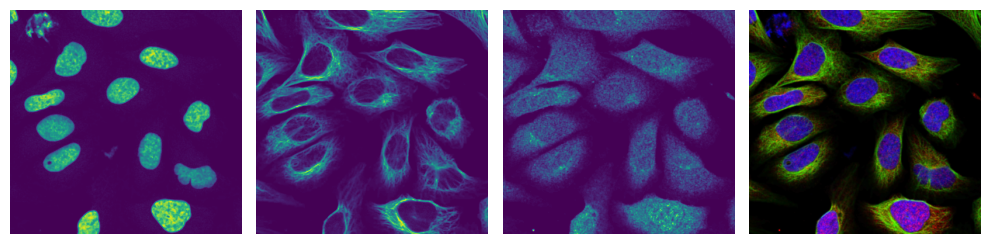

In [ ]:
# visualize input images as example
# it is not recommended to execute this block with large input images as it will compute for some time

def colorize(im, color, clip_percentile=0.0):
    """
    Helper function to create an RGB image from a single-channel image using a
    specific color.
    """
    # Check that we do just have a 2D image
    if im.ndim > 2 and im.shape[2] != 1:
        raise ValueError('This function expects a single-channel image!')

    # Rescale the image according to how we want to display it
    im_scaled = im.astype(np.float32) - np.percentile(im, clip_percentile)
    im_scaled = im_scaled / np.percentile(im_scaled, 100 - clip_percentile)
    im_scaled = np.clip(im_scaled, 0, 1)

    # Need to make sure we have a channels dimension for the multiplication to work
    im_scaled = np.atleast_3d(im_scaled)

    # Reshape the color (here, we assume channels last)
    color = np.asarray(color).reshape((1, 1, -1))
    return im_scaled * color

def generate_composite(images, colors = [(0, 0, 1),(0, 1, 0), (1, 0, 0), (1, 0, 1)], plot = False):
    colorized = []
    for image, color in zip(images, colors):
        image = colorize(image, color, 0.0)
        colorized.append(image)

    if plot:
        for i in colorized:
            plt.figure()
            plt.imshow(i)

    image = colorized[0]
    for i in range(len(colorized)-1):
        image += colorized[i+1]

    return(np.clip(image, 0, 1))

fig, axs = plt.subplots(1, 4, figsize = (10, 4));
axs[0].imshow(project.input_image[0]);
axs[0].axis("off");

axs[1].imshow(project.input_image[1]);
axs[1].axis("off");

axs[2].imshow(project.input_image[2]);
axs[2].axis("off");

img = generate_composite(project.input_image)

axs[3].imshow(img)
axs[3].axis("off");

fig.tight_layout()

In [7]:
project.segment()

[30/07/2024 23:56:48] Initialized temporary directory at /var/folders/35/p4c58_4n3bb0bxnzgns1t7kh0000gn/T/./CytosolSegmentationCellpose_ewhnyr65 for CytosolSegmentationCellpose
[30/07/2024 23:56:48] GPU Status for segmentation is True and will segment using the following device mps.
[30/07/2024 23:56:48] Segmenting nucleus using the following model: nuclei
[30/07/2024 23:56:50] Segmenting cytosol using the following model: cyto2
[30/07/2024 23:56:51] Performing filtering to match Cytosol and Nucleus IDs.
[30/07/2024 23:56:51] Removed 4 nuclei and 2 cytosols due to filtering.
[30/07/2024 23:56:51] After filtering, 7 matching nuclei and cytosol masks remain.
[30/07/2024 23:56:51] Segmentation debugging_seg_match_mask_results_nucleus written to sdata object.
[30/07/2024 23:56:51] Segmentation debugging_seg_match_mask_result_cytosol written to sdata object.
[30/07/2024 23:56:51] Total time to perform nucleus and cytosol mask matching filtering: 0.19 seconds
[30/07/2024 23:56:51] Segmentati

(-0.5, 298.5, 289.5, -0.5)

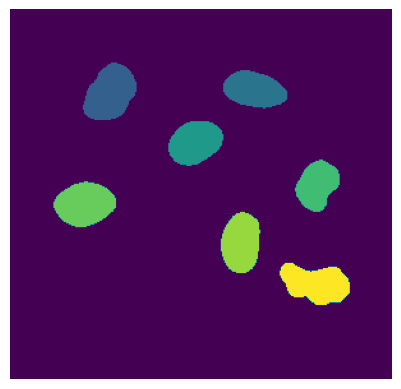

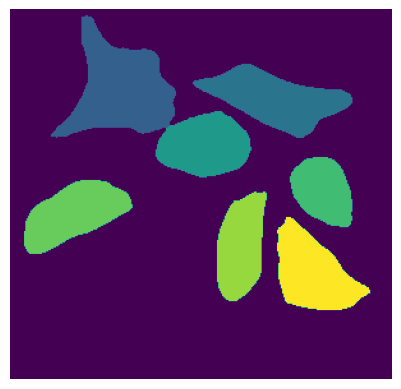

In [8]:
plt.figure()
plt.imshow(project.sdata["seg_all_nucleus"])
plt.axis("off")

plt.figure()
plt.imshow(project.sdata["seg_all_cytosol"])
plt.axis("off")

In [9]:
project.view_sdata()

/Users/sophia/Documents/GitHub/napari-spatialdata/src/napari_spatialdata/_view.py:211: FutureWarning: Private attribute access ('Window._dock_widgets') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  self._model = model if model else napari_viewer.window._dock_widgets["SpatialData"].widget().viewer_model._model


2024-07-30 23:57:28.602 | INFO     | napari_spatialdata._view:_on_layer_update:339 - Updating layer.
2024-07-30 23:57:28.603 | INFO     | napari_spatialdata._view:_on_layer_update:339 - Updating layer.
2024-07-30 23:58:02.321 | INFO     | napari_spatialdata._view:_on_layer_update:339 - Updating layer.
2024-07-30 23:58:02.324 | INFO     | napari_spatialdata._view:_on_layer_update:339 - Updating layer.
2024-07-30 23:58:08.553 | INFO     | napari_spatialdata._view:_on_layer_update:339 - Updating layer.
2024-07-30 23:58:08.555 | INFO     | napari_spatialdata._view:_on_layer_update:339 - Updating layer.
2024-07-30 23:58:29.271 | INFO     | napari_spatialdata._view:_on_layer_update:339 - Updating layer.
2024-07-30 23:58:29.274 | INFO     | napari_spatialdata._view:_on_layer_update:339 - Updating layer.


In [10]:
project.extract()

[30/07/2024 23:59:05] Initialized temporary directory at /var/folders/35/p4c58_4n3bb0bxnzgns1t7kh0000gn/T/./HDF5CellExtraction_5p9b675o for HDF5CellExtraction
[30/07/2024 23:59:05] Created new directory for extraction results: /Users/sophia/Documents/GitHub/SPARCSspatial/example_data/example_2/project/extraction/data
[30/07/2024 23:59:05] Setup output folder at /Users/sophia/Documents/GitHub/SPARCSspatial/example_data/example_2/project/extraction/data
[30/07/2024 23:59:05] Found 2 segmentation masks for the given key in the sdata object. Will be extracting single-cell images based on these masks: ['seg_all_nucleus', 'seg_all_cytosol']
[30/07/2024 23:59:05] Using seg_all_nucleus as the main segmentation mask to determine cell centers.
[30/07/2024 23:59:06] Points centers_cells written to sdata object.
[30/07/2024 23:59:06] Extraction Details:
[30/07/2024 23:59:06] --------------------------------
[30/07/2024 23:59:06] Number of input image channels: 3
[30/07/2024 23:59:06] Number of seg

Processing cell batches:   0%|          | 0/1 [00:00<?, ?it/s]

multiprocessing done.
[30/07/2024 23:59:07] Finished extraction in 0.08 seconds (86.18 cells / second)
[30/07/2024 23:59:07] Transferring results to final HDF5 data container.
[30/07/2024 23:59:07] number of cells too close to image edges to extract: 0
[30/07/2024 23:59:07] A total of 0 cells were too close to the image border to be extracted. Their cell_ids were saved to file /Users/sophia/Documents/GitHub/SPARCSspatial/example_data/example_2/project/segmentation/removed_classes.csv.
[30/07/2024 23:59:07] Transferring extracted single cells to .hdf5
[30/07/2024 23:59:07] single-cell index created.
[30/07/2024 23:59:07] single-cell data created
[30/07/2024 23:59:07] single-cell index labelled created.
[30/07/2024 23:59:07] channel information created.
[30/07/2024 23:59:08] Cleaned up temporary directory at <TemporaryDirectory '/var/folders/35/p4c58_4n3bb0bxnzgns1t7kh0000gn/T/./HDF5CellExtraction_5p9b675o'>


(7, 5, 110, 110)


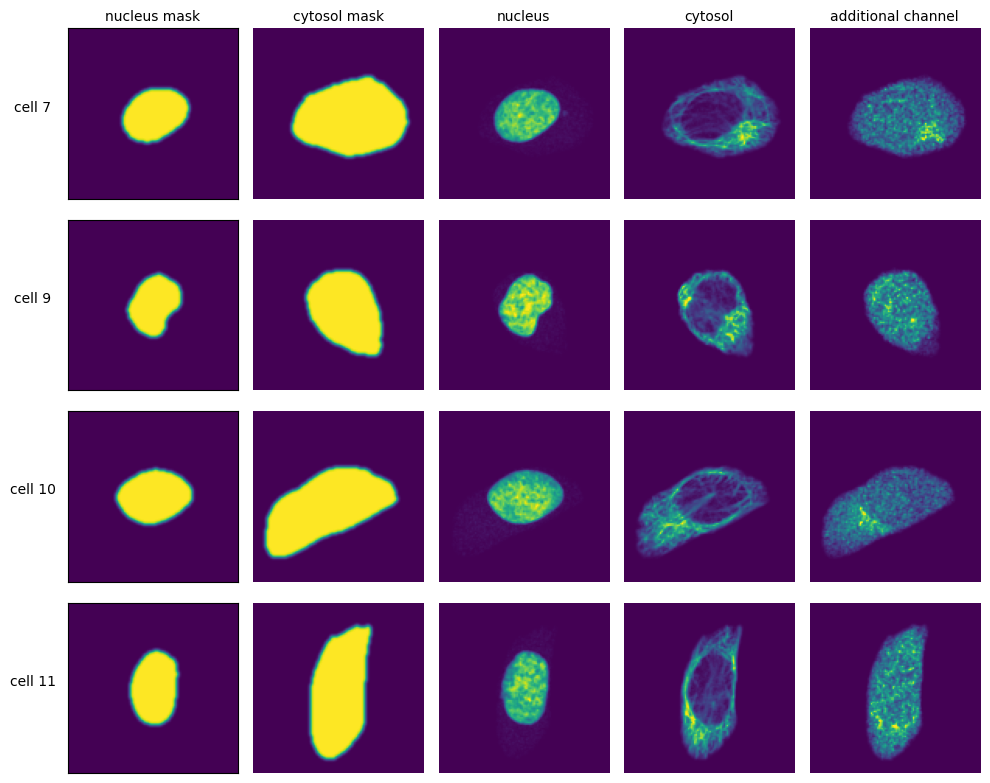

In [11]:
with h5py.File(f"{project_location}/extraction/data/single_cells.h5") as hf:
    index = hf.get("single_cell_index")
    images = hf.get("single_cell_data")

    print(images.shape)

    n_cells = [2, 3, 4, 5]
    fig, axs = plt.subplots(len(n_cells), 5, figsize = (5*2, len(n_cells)*2))
    labels = ["nucleus mask", "cytosol mask", "nucleus", "cytosol", "additional channel"]
    
    for i, id in enumerate(n_cells):
        cell_id = index[id][1]
        image = images[id]

        for n, _img in enumerate(image):
            axs[i, n].imshow(_img)

            if n == 0:
                axs[i, n].set_ylabel(f"cell {cell_id}", fontsize = 10, rotation = 0, labelpad = 25)
                axs[i, n].xaxis.set_visible(False)
                axs[i, n].tick_params(left=False, labelleft=False)
            else:
                axs[i, n].axis("off")
        
            if i == 0:
                axs[i, n].set_title(labels[n], fontsize = 10)
            
            
    fig.tight_layout()

In [12]:
project.classify()

Using extraction directory: /Users/sophia/Documents/GitHub/SPARCSspatial/example_data/example_2/project/extraction/data/single_cells.h5
[30/07/2024 23:59:12] Initialized temporary directory at /Users/sophia/Documents/GitHub/SPARCSspatial/example_data/example_2/CellFeaturizer_bfjq9d7q for CellFeaturizer
[30/07/2024 23:59:12] Started CellFeaturization of all available channels.
[30/07/2024 23:59:12] Created new directory for classification results: /Users/sophia/Documents/GitHub/SPARCSspatial/example_data/example_2/project/classification/complete_CellFeaturizer
[30/07/2024 23:59:12] CPU specified in config file but MPS available on system. Consider changing the device for the next run.
[30/07/2024 23:59:12] Reading data from path: /Users/sophia/Documents/GitHub/SPARCSspatial/example_data/example_2/project/extraction/data/single_cells.h5
[30/07/2024 23:59:12] Dataloader generated with a batchsize of 900 and 0 workers. Dataloader contains 1 entries.
[30/07/2024 23:59:12] Started processing

In [16]:
#load classification results
results = pd.read_csv(f"{project_location}/classification/complete_CellFeaturizer/calculated_image_features.csv")
results

,nucleus_area,cytosol_area,cytosol_only_area,1_mean_nucleus,1_median_nucleus,1_quant75_nucleus,1_quant25_nucleus,1_summed_intensity_nucleus,1_summed_intensity_area_normalized_nucleus,1_mean_cytosol,...,3_summed_intensity_cytosol,3_summed_intensity_area_normalized_cytosol,3_mean_cytosol_only,3_median_cytosol_only,3_quant75_cytosol_only,3_quant25_cytosol_only,3_summed_intensity_cytosol_only,3_summed_intensity_area_normalized_cytosol_only,label,cell_id
0,2043.0,6251.0,4208.0,0.071776,0.0,0.018875,0.0,868.48950,0.206390,0.071776,...,1368.37320,0.325184,0.113089,0.0,0.203369,0.0,1368.37320,0.325184,0,4
1,1746.0,4319.0,2573.0,0.065944,0.0,0.006208,0.0,797.92487,0.310115,0.065944,...,1269.12980,0.493249,0.104887,0.0,0.086365,0.0,1269.12980,0.493249,0,5
2,1768.0,3841.0,2073.0,0.061195,0.0,0.001278,0.0,740.45960,0.357192,0.061195,...,945.47424,0.456090,0.078138,0.0,0.018894,0.0,945.47424,0.456090,0,7
3,1586.0,2841.0,1255.0,0.060929,0.0,0.000000,0.0,737.24255,0.587444,0.060929,...,760.51430,0.605988,0.062852,0.0,0.000000,0.0,760.51430,0.605988,0,9
4,1972.0,4059.0,2087.0,0.059168,0.0,0.002635,0.0,715.93726,0.343046,0.059168,...,877.89610,0.420650,0.072553,0.0,0.031155,0.0,877.89610,0.420650,0,10
5,1820.0,3528.0,1708.0,0.061507,0.0,0.000008,0.0,744.23340,0.435734,0.061507,...,1044.98390,0.611817,0.086362,0.0,0.000142,0.0,1044.98390,0.611817,0,11
6,2014.0,4259.0,2245.0,0.049292,0.0,0.005032,0.0,596.43097,0.265671,0.049292,...,775.63350,0.345494,0.064102,0.0,0.065552,0.0,775.63350,0.345494,0,13


2024-07-31 10:45:09.246 | INFO     | napari_spatialdata._view:_on_layer_update:339 - Updating layer.
2024-07-31 10:45:09.250 | INFO     | napari_spatialdata._view:_on_layer_update:339 - Updating layer.
